In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.chdir('/notebooks/sentiment_analysis_tgdd/')

MODEL_TYPE = 'base'
PHOBERT_DIR = 'resource/PhoBERT_' + MODEL_TYPE + '_transformers/'

!pwd

/notebooks/sentiment_analysis_tgdd


In [2]:
from tqdm import tqdm, trange
import numpy as np
import pandas as pd
import random
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from vncorenlp import VnCoreNLP

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertForSequenceClassification, AdamW, BertConfig, BertPreTrainedModel
from transformers import get_linear_schedule_with_warmup, AdamW
# from pytorch_pretrained_bert import BertTokenizer, BertConfig
# from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

import argparse
from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary

Using TensorFlow backend.


## Load dataset

In [3]:
train = pd.read_csv('data/train_add_gen.csv', encoding='utf-16')
print(train.shape)
train.head()

(10187, 2)


,content,ground
0,Đôi khi màn hình chạy chậm...Vào mạng nhanh nó...,0
1,Dùng tốt nhưng thiếu 4g và bộ nhớ hơi kém và m...,0
2,Vào các ứng dụng hầu như rất chậm. Chơi game n...,0
3,Giảm gần 1 nữa lúc mua. F9 ra còn rẻ hơn f7 lú...,0
4,"Đã mua và sử dụng được 2 tháng, rất tuyệt. Xài...",1


In [4]:
test = pd.read_csv('data/test.csv', encoding='utf-16')
print(test.shape)
test.head()

(1552, 2)


,content,ground
0,Sản phẩm hay bị đơ! Dùng pin 4g hao nhanh. Hỗ ...,0
1,"Đẹp nhất, cấu hình cao nhất, pin trâu nhất tro...",1
2,"Trên cả tuyệt vời 😍 pin trâu, mượt, sang trọng...",1
3,Sản phẩm tầm trung Xài tạm ổn. Nói chung sản p...,0
4,oppo neo 7 thật quá đã. Tính năng cũng như HĐH...,1


## Process dataset

In [5]:
def text_normalize(df):
    # Convert text to lowercase
    df['content'] = df['content'].str.lower()
    # Remove numbers and words with numbers
    df['content'] = df['content'].str.replace('\w*\d\w*', ' ')
    # Remove punctuation
    df['content'] = df['content'].str.replace('[^\w\s]', ' ')
    # Remove whitespaces
    df['content'] =  df['content'].str.split().apply(lambda x : ' '.join(word for word in x))

In [6]:
text_normalize(train)
text_normalize(test)
test.tail()

,content,ground
1547,máy mình dùng một thời gian ngắn nhưng chậm sử...,0
1548,cho đến hôm nay máy vẫn bị loạn cảm ứng cập nh...,0
1549,đẹp chuẩn sài rất êm tôi rất hài lòng về dòng ...,1
1550,mặc dù mua máy cũ nhưng trông như máy mới mọi ...,1
1551,máy chạy tốt mình hài lòng mua từ tháng năm tớ...,0


## Tokenize

In [7]:
segmenter = VnCoreNLP('resource/VnCoreNLP/VnCoreNLP-1.1.1.jar', annotators="wseg", max_heap_size='-Xmx500m')

In [8]:
train.content = train.content.apply(lambda x: ' '.join(seg for seg in segmenter.tokenize(x)[0]))
test.content = test.content.apply(lambda x: ' '.join(seg for seg in segmenter.tokenize(x)[0]))                                                    

In [9]:
train.head()

,content,ground
0,đôi_khi màn_hình chạy chậm vào mạng nhanh nóng...,0
1,dùng tốt nhưng thiếu và bộ_nhớ hơi kém và màn_...,0
2,vào các ứng_dụng hầu_như rất chậm chơi game nh...,0
3,giảm gần nữa lúc mua ra còn rẻ hơn lúc mới ra ...,0
4,đã mua và sử_dụng được tháng rất tuyệt xài rất...,1


## Text and label encoding

##### Load `phoBERT` BPE encoder

In [10]:
# Load BPE encoder 
parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes', 
    default=PHOBERT_DIR + 'bpe.codes',
    required=False,
    type=str,  
    help='path to fastBPE BPE'
)
args = parser.parse_args(args=[])
bpe = fastBPE(args)

In [11]:
def make_padded_texts(texts, max_length):
    vocab = Dictionary()
    vocab.add_from_file(PHOBERT_DIR + 'dict.txt')
    encoded_texts = []
    for text in texts:
        # Encode the line using fast BPE & Add prefix <s> and suffix </s> 
        subwords = '<s> ' + bpe.encode(text) + ' </s>'
        subwords = bpe.encode(text)
        # Map subword tokens to corresponding indices in the dictionary
        input_ids = vocab.encode_line(
            subwords,
            append_eos=False,
            add_if_not_exist=False
        ).long().tolist()
        encoded_texts.append(input_ids)
    # Pad texts to the `max_length`
    padded_texts = pad_sequences(
        encoded_texts,
        maxlen=max_length,
        dtype="long",
        padding='post',
        truncating='post'
    )
    print(f'padded_texts shape: {padded_texts.shape}')
    return padded_texts

##### Set max sequence length

In [12]:
max_seq_len = 64 # tokens

In [13]:
X = make_padded_texts(train.content.tolist(), max_seq_len)

padded_texts shape: (10187, 64)


In [14]:
Y = torch.tensor(train.ground.values)
Y.shape

torch.Size([10187])

In [15]:
X_test = make_padded_texts(test.content.tolist(), max_seq_len)
Y_test = test.ground.values

padded_texts shape: (1552, 64)


##### Make attention masks
An array of 1s and 0s indicating which tokens are padding and which aren’t.

In [16]:
attention_masks = [[float(i>0) for i in ii] for ii in X]

In [17]:
test_attention_masks = [[float(i>0) for i in ii] for ii in X_test]

## Data Loader

##### Training & validation split

In [18]:
random_seed = 42

In [19]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, random_state=random_seed, test_size=0.2)
Mask_train, Mask_valid, _, _ = train_test_split(attention_masks, X, random_state=random_seed, test_size=0.2)

In [20]:
X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)
Y_train = torch.tensor(Y_train)
Y_valid = torch.tensor(Y_valid)
X_test = torch.tensor(X_test)
Y_test = torch.tensor(Y_test)
Mask_train = torch.tensor(Mask_train) 
Mask_valid = torch.tensor(Mask_valid)
Mask_test = torch.tensor(test_attention_masks)

In [21]:
# For prod
# X_train = torch.tensor(X)
# Y_train = torch.tensor(Y)
# Mask_train = torch.tensor(attention_masks)

##### Make data iterable

In [22]:
batch_size = 32

In [23]:
data_train = TensorDataset(X_train, Mask_train, Y_train)
data_train_sampler = RandomSampler(data_train)
DL_train = DataLoader(data_train, sampler=data_train_sampler, batch_size=batch_size)

data_valid = TensorDataset(X_valid, Mask_valid, Y_valid)
data_valid_sampler = SequentialSampler(data_valid)
DL_valid = DataLoader(data_valid, sampler=data_valid_sampler, batch_size=batch_size)

data_test = TensorDataset(X_test, Mask_test, Y_test)
data_test_sampler = SequentialSampler(data_test)
DL_test = DataLoader(data_test, sampler=data_test_sampler, batch_size=batch_size)

## Model

##### Load pretrained model

In [24]:
config = BertConfig.from_pretrained(PHOBERT_DIR + 'config.json')

In [25]:
model = BertForSequenceClassification.from_pretrained(
    PHOBERT_DIR + 'model.bin',
    config=config)

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.device_count()

1

In [27]:
model.cuda();

In [28]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (64001, 768)
bert.embeddings.position_embeddings.weight                (258, 768)
bert.embeddings.token_type_embeddings.weight                (1, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

##### Optimizer & Learning Rate Scheduler

In [29]:
# FULL_FINETUNING = True
# if FULL_FINETUNING:
#     param_optimizer = list(model.named_parameters())
#     no_decay = ['bias', 'gamma', 'beta']
#     optimizer_grouped_parameters = [
#         {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
#          'weight_decay_rate': 0.01},
#         {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
#          'weight_decay_rate': 0.0}
#     ]
# else:
#     param_optimizer = list(model.classifier.named_parameters()) 
#     optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
    
# optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)

In [30]:
# Creating optimizer and lr schedulers
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False

In [31]:
epochs = 5
total_steps = len(DL_train) * epochs
total_steps

1275

In [32]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=total_steps)

##### Flat accuracy

In [33]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [34]:
def seed_everything(seed_val=random_seed):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
seed_everything()

##### Training

In [35]:
max_grad_norm = 1.0
training_stats = []

for epoch in trange(epochs, desc='Epoch'):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(DL_train):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        model.zero_grad()
        loss, _ = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        scheduler.step()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in DL_valid:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss, _ = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss / nb_eval_steps
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': tr_loss / nb_tr_steps,
            'Valid. Loss': eval_loss,
            'Valid. Accur.': eval_accuracy / nb_eval_steps
        }
    )

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.4782964742358993


Epoch:  20%|██        | 1/5 [03:37<14:31, 217.85s/it]

Validation loss: 0.38343932112911716
Validation Accuracy: 0.8479669744318182
Train loss: 0.2706414441705919


Epoch:  40%|████      | 2/5 [07:15<10:53, 217.70s/it]

Validation loss: 0.2972825379110873
Validation Accuracy: 0.8772638494318182
Train loss: 0.22492055717636558


Epoch:  60%|██████    | 3/5 [10:52<07:15, 217.57s/it]

Validation loss: 0.34541310637723655
Validation Accuracy: 0.8772638494318182
Train loss: 0.17707982849256665


Epoch:  80%|████████  | 4/5 [14:29<03:37, 217.47s/it]

Validation loss: 0.25320686580380425
Validation Accuracy: 0.8970614346590909
Train loss: 0.16090385148338243


Epoch: 100%|██████████| 5/5 [18:06<00:00, 217.38s/it]

Validation loss: 0.2528401301242411
Validation Accuracy: 0.9041193181818182


##### Train/val loss

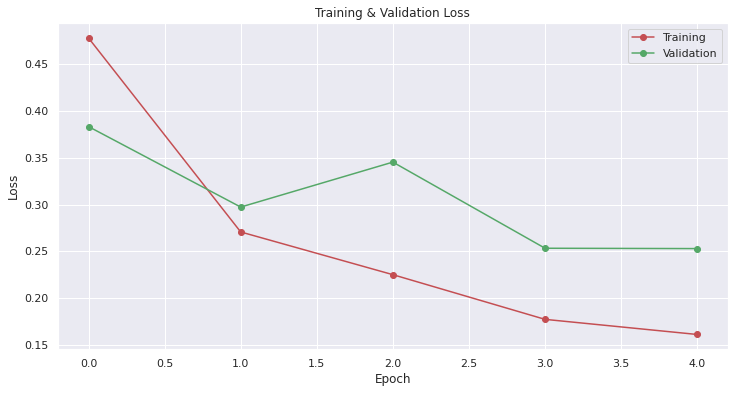

In [36]:
df_stats = pd.DataFrame(data=training_stats)
# Use the 'epoch' as the row index.
# df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')
# Increase the plot size and font size.
# sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'r-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# plt.xticks([i + 1 for i in range(epochs)])

plt.show()

##### Test

In [37]:
model.eval()
predictions = []
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
for batch in DL_test:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        tmp_eval_loss, _ = model(b_input_ids, token_type_ids=None,
                              attention_mask=b_input_mask, labels=b_labels)
        logits = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask)[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    predictions.extend(np.argmax(logits, axis=1).flatten())    
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy

    nb_eval_examples += b_input_ids.size(0)
    nb_eval_steps += 1

print("Test loss: {}".format(eval_loss/nb_eval_steps))
print("Test Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Test loss: 0.3368847397517185
Test Accuracy: 0.8698979591836735


In [38]:
target_names = ['negative', 'positive']
print(classification_report(Y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.92      0.81      0.86       758
    positive       0.83      0.93      0.88       794

    accuracy                           0.87      1552
   macro avg       0.88      0.87      0.87      1552
weighted avg       0.87      0.87      0.87      1552



In [39]:
pred_test = pd.DataFrame.from_dict({
    'text': test.content,
    'ground': test.ground,
    'prediction': predictions
})

In [40]:
pred_test[pred_test.ground != pred_test.prediction]

,text,ground,prediction
3,sản_phẩm tầm trung xài tạm ổn nói_chung sản ph...,0,1
4,oppo neo thật quá đã tính_năng cũng như hđh ph...,1,0
17,là ipan of ip nhưng thử cảm_nhận coi ss ntn đá...,0,1
18,sản_phẩm tạm ổn cấu_hình yếu quá nokia chạy hệ...,0,1
24,dùng ok hiện_tại thì chưa thấy có vấn_đề gì cả...,0,1
...,...,...,...
1515,vân tay ko nhạy cho lắm tay_phải thật sạch mới...,0,1
1526,htc làm pin khá chạy mượt nhưng vân tay còn tệ...,0,1
1527,rất nóg máy xai wifi pin lâu xíu thì rất mau h...,0,1
1537,mọi thứ tốt nhưng máy nóng mua tuần về rớt lần...,0,1
